a notebook to perform linear mmd test on MFDFA 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import freqopttest.util as util
import freqopttest.data as data
import freqopttest.kernel as kernel
import freqopttest.tst as tst
import freqopttest.glo as glo
import sys
import time
import os
import pandas as pd

In [42]:
mfdfaDataFrames = '/media/ak/T71/August11th2022Experiments/mfdfaDataFrames'
symbol = 'FB1'
variable = 'alpha'

file_name = [f for f in os.listdir(mfdfaDataFrames) if str(symbol) and str(variable) in f][0]
file_loc = os.path.join(mfdfaDataFrames, file_name)
unpickled_Df = pd.read_pickle(file_loc)


In [43]:
X = np.array(unpickled_Df.iloc[:, 0:3])
Y = np.array(unpickled_Df.iloc[:, 3:6])
data_sample =data.TSTData(X, Y)
tr, te = data_sample.split_tr_te(tr_proportion=0.5, seed=10)

In [44]:
# choose the best kernel that maximizes the test power 
med = util.meddistance(tr.stack_xy())
widths = [ (med*f) for f in 2.0**np.linspace(-1, 4, 25)]
list_kernels = [kernel.KGauss( w**2 ) for w in widths]

besti, powers = tst.LinearMMDTest.grid_search_kernel(tr, list_kernels, alpha=0.01)

In [67]:
med_data = util.meddistance(data_sample.stack_xy())
print(med_data , med)

0.257840690008697 0.2559284203912613


Text(0.5, 1.0, 'median distance = 0.256. Best width: 0.128')

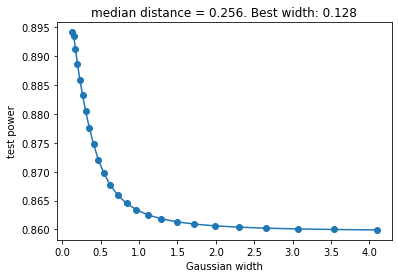

In [45]:
plt.plot(widths, powers, 'o-')
plt.xlabel('Gaussian width')
plt.ylabel('test power')
plt.title('median distance = %.3g. Best width: %.3g'%(med, widths[besti]) )

In [46]:
# The actual test 
best_ker = list_kernels[besti]
lin_mmd_test = tst.LinearMMDTest(best_ker, alpha=0.01)
test_result = lin_mmd_test.perform_test(te)
test_result

{'alpha': 0.01,
 'pvalue': 0.002297832631142959,
 'test_stat': 0.726835103641835,
 'h0_rejected': True}

In [60]:
lin_mmd_test.two_moments(X,Y , best_ker)

(0.8853950870295467, 1.5438049487251293)

In [61]:
lin_mmd_test.variance(X,Y , best_ker)

-1.0797456931387486

In [64]:
rep = 500
te_size = 5000
alpha = 0.01
lin_mmd_test = tst.LinearMMDTest(best_ker, alpha)
pvals = np.zeros(rep)
for r in range(rep):
    te = ss.sample(te_size, seed=r+34000)
    test_result = lin_mmd_test.perform_test(te)
    pvals[r] = test_result['pvalue']
  
# plot
type1 = np.sum(pvals < alpha)/float(rep)
print('type1: %.4g'%type1)
    

NameError: name 'ss' is not defined

In [ ]:
## how do i sample from the distribution for the test set?

### A notebook to test quadratic MMD two-sample test

### Test Permutations

In [49]:
xtr, ytr = tr.xy()
xytr = tr.stack_xy()
sig2 = util.meddistance(xytr, subsample=1000)
k = kernel.KGauss(sig2)

In [51]:
med = util.meddistance(tr.stack_xy(), 1000)
list_gwidth = np.hstack( ( (med**2) *(2.0**np.linspace(-4, 4, 20) ) ) )
list_gwidth.sort()
list_kernels = [kernel.KGauss(gw2) for gw2 in list_gwidth]
besti, powers = tst.QuadMMDTest.grid_search_kernel(tr, list_kernels, alpha)

(1/20) KGauss(w2=0.004): mmd2: 0.0939, var: 0.00139, power obj: 1.92101, took: 0.00043129920959472656
(2/20) KGauss(w2=0.005): mmd2: 0.102, var: 0.00163, power obj: 1.99339, took: 0.0003604888916015625
(3/20) KGauss(w2=0.007): mmd2: 0.111, var: 0.00187, power obj: 2.06571, took: 0.00034880638122558594
(4/20) KGauss(w2=0.010): mmd2: 0.119, var: 0.00213, power obj: 2.13138, took: 0.0003459453582763672
(5/20) KGauss(w2=0.013): mmd2: 0.126, var: 0.00234, power obj: 2.18562, took: 0.00034809112548828125
(6/20) KGauss(w2=0.018): mmd2: 0.131, var: 0.00245, power obj: 2.22848, took: 0.00034427642822265625
(7/20) KGauss(w2=0.024): mmd2: 0.131, var: 0.00237, power obj: 2.26543, took: 0.0003705024719238281
(8/20) KGauss(w2=0.032): mmd2: 0.127, var: 0.00204, power obj: 2.30612, took: 0.006884098052978516
(9/20) KGauss(w2=0.042): mmd2: 0.119, var: 0.00152, power obj: 2.36491, took: 0.00037550926208496094
(10/20) KGauss(w2=0.057): mmd2: 0.107, var: 0.000873, power obj: 2.46682, took: 0.0003988742828

med^2: 0.065
best width^2: 0.076


Text(0, 0.5, 'Approx. test power')

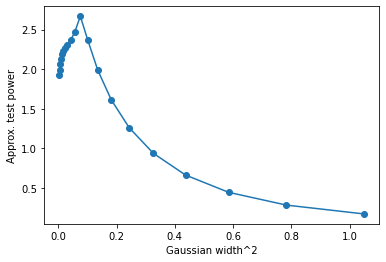

In [52]:
print ('med^2: %.3f'%med**2)
print ('best width^2: %.3f'%(list_gwidth[besti]))
plt.plot(list_gwidth, powers, 'o-')
plt.xlabel('Gaussian width^2')
plt.ylabel('Approx. test power')

In [53]:
k = kernel.KGauss(list_gwidth[besti])
mmd_test = tst.QuadMMDTest(k, n_permute=200, alpha=alpha)
test_result = mmd_test.perform_test(te)
test_result

{'alpha': 0.01,
 'pvalue': 0.025,
 'test_stat': 0.08572992873612706,
 'h0_rejected': False,
 'list_permuted_mmd2': array([-0.01022138, -0.00212186, -0.0171437 , -0.01784824,  0.02912588,
        -0.02352642,  0.00922356, -0.01451411, -0.0073835 ,  0.01120549,
         0.02012269, -0.02456168,  0.00322698, -0.02071388, -0.00699467,
         0.02968152, -0.00822205, -0.01658181,  0.01264064,  0.00070653,
        -0.01519688, -0.02334762, -0.02258724,  0.01935524, -0.01724654,
         0.08707283, -0.00981521,  0.0416121 ,  0.03974041, -0.01469769,
         0.02597869,  0.03256511, -0.00043627,  0.03265845, -0.00739738,
        -0.00857426, -0.01152219,  0.0411402 , -0.00709379, -0.0045673 ,
        -0.01638682, -0.00846645, -0.02508857,  0.0238718 ,  0.00243225,
        -0.01215654, -0.0114042 , -0.02400493,  0.00200585, -0.01559514,
        -0.01504642, -0.0128679 , -0.02448587,  0.04412327, -0.02522617,
        -0.01310084,  0.03697362, -0.0166782 , -0.02158297, -0.01955583,
         0

/home/ak/anaconda3/envs/kernels/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


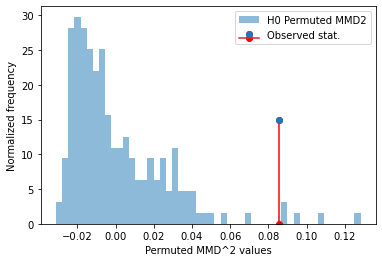

In [57]:
permuted_mmd2s = test_result['list_permuted_mmd2']
stat = test_result['test_stat']
bins = plt.hist(permuted_mmd2s, bins=50, density=True,stacked=True, label='H0 Permuted MMD2', alpha = 0.5);
plt.xlabel('Permuted MMD^2 values')
plt.ylabel('Normalized frequency')
plt.stem([stat], [max(bins[0])/2], 'or-', label='Observed stat.')
plt.legend()

In [89]:
LinearMMDOutputFiles = '/media/ak/T71/August11th2022Experiments/ExperimentOne/LinearMMDOutputFiles' 

In [93]:
linear_mmd_output_files = os.listdir(LinearMMDOutputFiles)
linear_mmd_output_files

['FB1_alpha_linear_test_ONE.pkl',
 'FB1_alpha_linear_test_TWO.pkl',
 'FB1_tau_linear_test_ONE.pkl',
 'FB1_tau_linear_test_TWO.pkl',
 'FB1_tau_1_5_linear_test_ONE.pkl',
 'FB1_tau_1_5_linear_test_TWO.pkl',
 'FB1_tau_shift_1_wind_5_linear_test_ONE.pkl',
 'FB1_tau_shift_1_wind_5_linear_test_TWO.pkl',
 'FB1_tau_shift_1_wind_4_linear_test_ONE.pkl',
 'FB1_tau_shift_1_wind_4_linear_test_TWO.pkl',
 'FB1_tau_shift_2_wind_4_linear_test_ONE.pkl',
 'FB1_tau_shift_2_wind_4_linear_test_TWO.pkl',
 'FB1_tau_shift_2_wind_6_linear_test_ONE.pkl',
 'FB1_tau_shift_2_wind_6_linear_test_TWO.pkl',
 'FB1_alpha_shift_2_wind_6_linear_test_ONE.pkl',
 'FB1_alpha_shift_2_wind_6_linear_test_TWO.pkl',
 'JB1_alpha_shift_2_wind_6_linear_test_ONE.pkl',
 'JB1_alpha_shift_2_wind_6_linear_test_TWO.pkl',
 'JB1_tau_shift_2_wind_6_linear_test_ONE.pkl',
 'JB1_tau_shift_2_wind_6_linear_test_TWO.pkl',
 'JB1_tau_shift_1_wind_5_linear_test_ONE.pkl',
 'JB1_tau_shift_1_wind_5_linear_test_TWO.pkl']

In [83]:
file = os.path.join(LinearMMDOutputFiles, linear_mmd_output_files[1])

In [85]:
pd.read_pickle(file)

defaultdict(dict,
            {0: {'test_result': {'alpha': 0.01,
               'pvalue': 0.0061535854260501965,
               'test_stat': 0.020126803650519946,
               'h0_rejected': True},
              'test_variance': -0.00022224307687023599,
              'med_on_test_data': 0.08939744694107624,
              'two_moments': (0.020126803650519946, 0.002230351743149445),
              'compute_unbiased_linear_estimator': 0.020126803650519946},
             1: {'test_result': {'alpha': 0.01,
               'pvalue': 0.002117934721322524,
               'test_stat': 0.016381918739546846,
               'h0_rejected': True},
              'test_variance': -0.0002075241698978175,
              'med_on_test_data': 0.06592413703598193,
              'two_moments': (0.016381918739546846, 0.0011318901268680727),
              'compute_unbiased_linear_estimator': 0.016381918739546846},
             2: {'test_result': {'alpha': 0.01,
               'pvalue': 0.00038582778258170955,
